Six-Hump Camel synthetic function:

GP EI versus GP dEI (winner)

https://www.sfu.ca/~ssurjano/camel6.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'SixHumpCamel'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'SixHumpCamel':
    
    # True y bounds:
    operator = -1
    y_lb = -1.0316 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb_x1 = -3 
    ub_x1 = +3
    lb_x2 = -2 
    ub_x2 = +2

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * ((4 - 2.1 * x1_training ** 2 + 1 / 3 * x1_training ** 4) * x1_training ** 2 +
                (x1_training * x2_training) + (-4 + 4 * x2_training ** 2) * x2_training ** 2)
        

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Surrogate derivatives: 

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
n_start_AcqFunc = max_iter
inverse = -1


In [10]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

n_start = n_start_AcqFunc

class GPGO_approx(GPGO):
  
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         GP EI: maximum y '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
  
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncApprox = -min(self.f_best)
        self.history.append(self.min_acqfuncApprox)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncApprox = self.min_acqfuncApprox
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncApprox = BOLD + OKGREEN + str(min_acqfuncApprox) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncApprox))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        GP dEI: maximum y '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncExact = -min(self.f_best)
        self.history.append(self.min_acqfuncExact) 
        
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncExact = self.min_acqfuncExact
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncExact = BOLD + OKGREEN + str(min_acqfuncExact) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncExact))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
###Reproducible set-seeds:

run_num_8 = 8

rounder = 3


In [13]:
### APPROXIMATE GP EI GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8_20 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param)
approx_8_20.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    
1  	 [-0.77086886  0.84272184]	 0.23242422233356008	 0.03190064766213015	 0.91523883411738


In [14]:
approx_8_20rms = pd.Series(np.round(-approx_8_20.f_best, rounder)).value_counts(sort=True)
approx_8_20rms_df = pd.DataFrame({'Frequency':approx_8_20rms.values,'GP EI':approx_8_20rms.index})
approx_8_20rms_df


,Frequency,GP EI
0,10,0.915
1,6,0.743
2,3,0.000
3,1,0.855


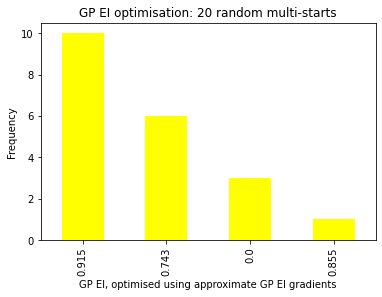

In [15]:
ax = approx_8_20rms.plot.bar(title="GP EI optimisation: 20 random multi-starts", xlabel="GP EI, optimised using approximate GP EI gradients", ylabel="Frequency", color="yellow")


In [16]:
### EXACT GP EI GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8_20 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param)
exact_8_20.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    
1	 [-0.57246742  0.6534526 ]	 -0.25569579328253045	 -0.25569579328253045	 0.9022574499586161


In [17]:
exact_8_20rms = pd.Series(np.round(-exact_8_20.f_best, rounder)).value_counts(sort=True)
exact_8_20rms_df = pd.DataFrame({'Frequency':exact_8_20rms.values,'GP EI':exact_8_20rms.index})
exact_8_20rms_df


,Frequency,GP EI
0,3,0.000
1,2,0.531
2,1,0.902
3,1,0.871
4,1,0.895
5,1,0.838
6,1,0.894
7,1,0.513
8,1,0.544
9,1,0.809


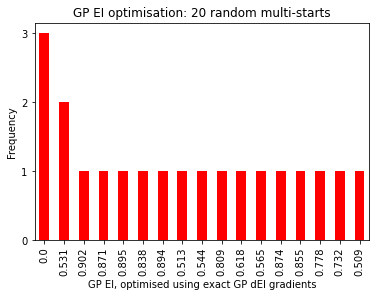

In [18]:
ax = exact_8_20rms.plot.bar(title="GP EI optimisation: 20 random multi-starts", xlabel="GP EI, optimised using exact GP dEI gradients", ylabel="Frequency", color="red", yticks=[0,1,2,3])


In [19]:
n_start = 50


In [20]:
### APPROXIMATE GP EI GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_8)
surrogate_approx_8_50rms = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8_50 = GPGO_approx(surrogate_approx_8_50rms, Acquisition_grad(util), f_syn_polarity, param)
approx_8_50.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    
1  	 [-0.77086845  0.8427215 ]	 0.23242267719150145	 0.03190064766213015	 0.9152388341174134


In [21]:
approx_8_50rms = pd.Series(np.round(-approx_8_50.f_best, rounder)).value_counts(sort=True)
approx_8_50rms_df = pd.DataFrame({'Frequency':approx_8_50rms.values,'GP EI':approx_8_50rms.index})
approx_8_50rms_df


,Frequency,GP EI
0,26,0.915
1,13,0.743
2,9,0.000
3,1,0.855
4,1,0.509


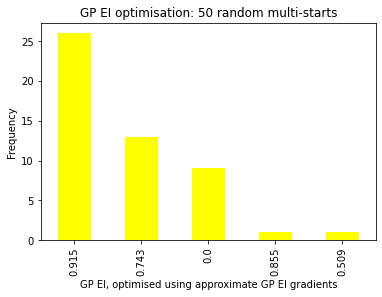

In [22]:
ax = approx_8_50rms.plot.bar(title="GP EI optimisation: 50 random multi-starts", xlabel="GP EI, optimised using approximate GP EI gradients", ylabel="Frequency", color="yellow")


In [23]:
### EXACT GP EI GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_8)
surrogate_exact_8_50rms = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8_50 = GPGO_exact(surrogate_exact_8_50rms, Acquisition_grad(util), f_syn_polarity, param)
exact_8_50.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    
1  	 [-0.76096154  0.82951198]	 0.1870991607718503	 0.03190064766213015	 0.915190289526394


In [24]:
exact_8_50rms = pd.Series(np.round(-exact_8_50.f_best, rounder)).value_counts(sort=True)
exact_8_50rms_df = pd.DataFrame({'Frequency':exact_8_50rms.values,'GP EI':exact_8_50rms.index})
exact_8_50rms_df


,Frequency,GP EI
0,9,0.000
1,2,0.874
2,2,0.531
3,1,0.902
4,1,0.850
5,1,0.712
6,1,0.823
7,1,0.915
8,1,0.573
9,1,0.590


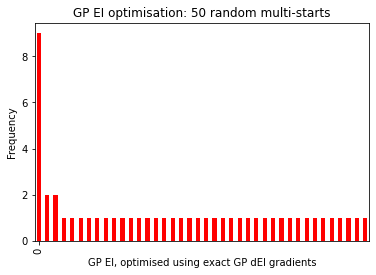

In [25]:
ax = exact_8_50rms.plot.bar(title="GP EI optimisation: 50 random multi-starts", xlabel="GP EI, optimised using exact GP dEI gradients", ylabel="Frequency", color="red", xticks=[0])


In [26]:
n_start = 100


In [27]:
### APPROXIMATE GP EI GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_8)
surrogate_approx_8_100rms = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8_100 = GPGO_approx(surrogate_approx_8_100rms, Acquisition_grad(util), f_syn_polarity, param)
approx_8_100.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    
1  	 [-0.77086855  0.84272133]	 0.23242252299996824	 0.03190064766213015	 0.9152388341174278


In [28]:
approx_8_100rms = pd.Series(np.round(-approx_8_100.f_best, rounder)).value_counts(sort=True)
approx_8_100rms_df = pd.DataFrame({'Frequency':approx_8_100rms.values,'GP EI':approx_8_100rms.index})
approx_8_100rms_df


,Frequency,GP EI
0,49,0.915
1,28,0.000
2,20,0.743
3,1,0.855
4,1,0.509
5,1,0.858


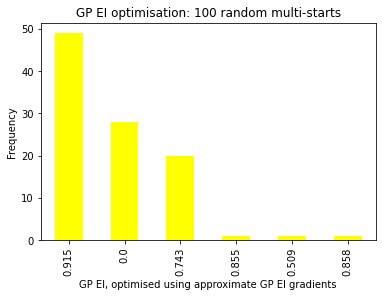

In [29]:
ax = approx_8_100rms.plot.bar(title="GP EI optimisation: 100 random multi-starts", xlabel="GP EI, optimised using approximate GP EI gradients", ylabel="Frequency", color="yellow")


In [30]:
### EXACT GP EI GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_8)
surrogate_exact_8_100rms = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8_100 = GPGO_exact(surrogate_exact_8_100rms, Acquisition_grad(util), f_syn_polarity, param)
exact_8_100.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    
1  	 [-0.76096154  0.82951198]	 0.1870991607718503	 0.03190064766213015	 0.915190289526394


In [31]:
exact_8_100rms = pd.Series(np.round(-exact_8_100.f_best, rounder)).value_counts(sort=True)
exact_8_100rms_df = pd.DataFrame({'Frequency':exact_8_100rms.values,'GP EI':exact_8_100rms.index})
exact_8_100rms_df


,Frequency,GP EI
0,28,0.000
1,3,0.869
2,3,0.915
3,2,0.889
4,2,0.531
...,...,...
58,1,0.591
59,1,0.507
60,1,0.618
61,1,0.610


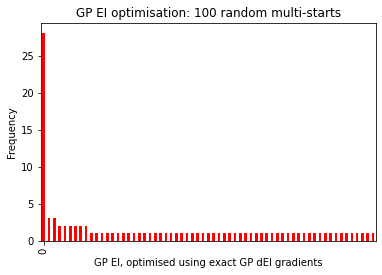

In [32]:
ax = exact_8_100rms.plot.bar(title="GP EI optimisation: 100 random multi-starts", xlabel="GP EI, optimised using exact GP dEI gradients", ylabel="Frequency", color="red", xticks=[0])


In [33]:
print(approx_8_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
0.915 &  10 \\
0.743 &   6 \\
0.000 &   3 \\
0.855 &   1 \\
\bottomrule
\end{tabular}



In [34]:
print(exact_8_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &  0 \\
\midrule
0.000 &  3 \\
0.531 &  2 \\
0.902 &  1 \\
0.871 &  1 \\
0.895 &  1 \\
0.838 &  1 \\
0.894 &  1 \\
0.513 &  1 \\
0.544 &  1 \\
0.809 &  1 \\
0.618 &  1 \\
0.565 &  1 \\
0.874 &  1 \\
0.855 &  1 \\
0.778 &  1 \\
0.732 &  1 \\
0.509 &  1 \\
\bottomrule
\end{tabular}



In [35]:
print(approx_8_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
0.915 &  26 \\
0.743 &  13 \\
0.000 &   9 \\
0.855 &   1 \\
0.509 &   1 \\
\bottomrule
\end{tabular}



In [36]:
print(exact_8_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &  0 \\
\midrule
0.000 &  9 \\
0.874 &  2 \\
0.531 &  2 \\
0.902 &  1 \\
0.850 &  1 \\
0.712 &  1 \\
0.823 &  1 \\
0.915 &  1 \\
0.573 &  1 \\
0.590 &  1 \\
0.591 &  1 \\
0.507 &  1 \\
0.610 &  1 \\
0.754 &  1 \\
0.620 &  1 \\
0.650 &  1 \\
0.822 &  1 \\
0.664 &  1 \\
0.550 &  1 \\
0.876 &  1 \\
0.904 &  1 \\
0.524 &  1 \\
0.911 &  1 \\
0.618 &  1 \\
0.732 &  1 \\
0.778 &  1 \\
0.855 &  1 \\
0.565 &  1 \\
0.809 &  1 \\
0.871 &  1 \\
0.544 &  1 \\
0.513 &  1 \\
0.894 &  1 \\
0.838 &  1 \\
0.895 &  1 \\
0.509 &  1 \\
0.889 &  1 \\
0.539 &  1 \\
0.734 &  1 \\
0.892 &  1 \\
\bottomrule
\end{tabular}



In [37]:
print(approx_8_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
0.915 &  49 \\
0.000 &  28 \\
0.743 &  20 \\
0.855 &   1 \\
0.509 &   1 \\
0.858 &   1 \\
\bottomrule
\end{tabular}



In [38]:
print(exact_8_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
0.000 &  28 \\
0.869 &   3 \\
0.915 &   3 \\
0.889 &   2 \\
0.531 &   2 \\
0.822 &   2 \\
0.895 &   2 \\
0.664 &   2 \\
0.874 &   2 \\
0.676 &   1 \\
0.683 &   1 \\
0.550 &   1 \\
0.876 &   1 \\
0.892 &   1 \\
0.506 &   1 \\
0.001 &   1 \\
0.715 &   1 \\
0.547 &   1 \\
0.908 &   1 \\
0.604 &   1 \\
0.897 &   1 \\
0.533 &   1 \\
0.914 &   1 \\
0.913 &   1 \\
0.815 &   1 \\
0.813 &   1 \\
0.888 &   1 \\
0.847 &   1 \\
0.663 &   1 \\
0.827 &   1 \\
0.656 &   1 \\
0.532 &   1 \\
0.910 &   1 \\
0.902 &   1 \\
0.850 &   1 \\
0.650 &   1 \\
0.620 &   1 \\
0.732 &   1 \\
0.778 &   1 \\
0.855 &   1 \\
0.565 &   1 \\
0.809 &   1 \\
0.871 &   1 \\
0.544 &   1 \\
0.513 &   1 \\
0.894 &   1 \\
0.838 &   1 \\
0.509 &   1 \\
0.539 &   1 \\
0.734 &   1 \\
0.524 &   1 \\
0.911 &   1 \\
0.754 &   1 \\
0.904 &   1 \\
0.712 &   1 \\
0.823 &   1 \\
0.573 &   1 \\
0.590 &   1 \\
0.591 &   1 \\
0.507 &   1 \\
0.618 &   1 \\
0.610 &   1 \\
0.638 &   1 \\
\bott